In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection, preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, precision_score, recall_score, confusion_matrix
import statsmodels.api as sm
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

# Preliminaries

Data processing, feature engineering and feature selection.

In [10]:
data = pd.read_csv("data.csv")
data

,Date,Avg Spend,Breakfast,Column_Total,Day,Dinner,Lunch,Month,New_Column,Notes,Revenue,Time,Total,Weather
0,2026-01-02,18.293582,26,4112.303582,Thursday,22,155,12,weekday,0,3677.01,00:00:00,202,PM Rain
1,2026-01-01,16.696031,43,3658.726031,Wednesday,14,139,12,weekday,0,3239.03,00:00:00,195,PM Rain
2,2025-12-31,18.163988,28,3521.533988,Tuesday,1,146,12,weekday,0,3142.37,00:00:00,174,Overcast
3,2025-12-30,10.000000,10,25.000000,Monday,11,11,22,weekday,Christmas,10.00,00:00:00,11,0
4,2025-12-29,17.293772,62,2231.783772,Sunday,1,53,12,weekend,Christmas Eves,1971.49,00:00:00,115,PM Rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8760,2002-01-10,9.567174,8,1609.837174,Wednesday,21,111,1,weekday,0,1320.27,00:00:00,139,0
8761,2002-01-09,11.112474,5,1287.022474,Tuesday,1,93,1,weekday,0,1077.91,00:00:00,98,0
8762,2002-01-08,20.244390,13,1028.284390,Monday,11,90,11,weekday,Warm,850.04,00:00:00,93,Part Sunny
8763,2002-01-07,9.220980,55,2762.360980,Sunday,30,162,1,weekend,0,2259.14,00:00:00,246,0


In [4]:
# Feature Selection
meals = data.reset_index()[["Breakfast ", "Lunch", "Dinner"]] # Independent variables
revenue = data.reset_index()["Revenue"] # Dependent variables

# Generic form: assume X are the features and y is the corresponding labels.
# X = data.drop('label_column', axis=1)
# y = data['label_column']

### Feature standardization

**IMP!** Data must be **standardized before being split** into the training and test datasets.

*  **Standard Scaler**: useful when features follow a **normal distribution**. Use in **linear regression** (because standardizing the features to have zero mean and unit variance help meet the assumptions of LS of data following a normal disitribution), **logistic regression** (same as linear regression), **k-means clustering** (because it uses the Euclidean distance between data points to determine their similarity).

In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(data)
pd.DataFrame(data)

*  **MinMax Scaler**: use in **neural networks** (with range 0 to 1 or -1 to 1).

In [ ]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
pd.DataFrame(data)

**Gradient Boosting Machines do not require scaling**. These algorithms are generally less sensitive to the scale of the data because they are based on decision trees, which are scale-invariant. However, scaling might help in convergence and when features have extreme differences in scales.

**ARIMA does not require scaling**. However, they require stationary data, so data must be transformed through differenciencing.

### Train/Test split

`X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)`

*  `stratify=y` stratifies the sample so that all classes in the target variable (y) are equally represented. If y is a continuous variable rather than discrete class labels, then stratify should not be used, as it's meant for stratification based on class proportions.

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Training regularization (to address multicollinearity/overfitting)

https://www.dataquest.io/blog/regularization-in-machine-learning/

# Regression

We use **R-squared** score for evaluation.

## Linear Regression (OLS)

### Model Analysis (all data used to train the model)

In [5]:
# Ordinary Least Squares
model = sm.OLS(revenue, meals)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                Revenue   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          6.401e+04
Date:                Sun, 14 Apr 2024   Prob (F-statistic):                        0.00
Time:                        09:25:09   Log-Likelihood:                         -70308.
No. Observations:                8765   AIC:                                  1.406e+05
Df Residuals:                    8762   BIC:                                  1.406e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

*  **R-squared**: approximately 95.6% of the variance in Revenue can be explained by the model.
*  **P>|t|**: A p-value below a certain threshold (commonly 0.05) suggests that there is strong evidence against the null hypothesis, meaning it's statistically significant. Here, all p-values are 0.000, indicating that all meal types are statistically significant predictors of 'Revenue'.
*  **Condition Number** (Cond. No.): This is a test for multicollinearity. Higher values (generally above 30) indicate potential multicollinearity problems, which means that some independent variables are highly correlated with each other. This can be addressed with **regularization**.
*  **Residuals**:
 
Omnibus: Tests the skewness and kurtosis of the residuals. A non-significant value (p-value > 0.05) typically indicates that residuals are normally distributed. Here, the Omnibus test is significant (Prob(Omnibus) is 0.000), suggesting that the residuals are not normally distributed.
*  **Confidence intervals**: If a coefficient is not distinguishable from zero, then there is not any relationship between the independent variable and the observations.  Thus, if the confidence interval for the parameter includes zero, the associated independent variable may not have any predictive value.

In [6]:
print('Confidence Intervals: {}'.format(results.conf_int()))

Confidence Intervals:                     0          1
Breakfast   18.003137  19.170066
Lunch       12.385966  12.887152
Dinner      15.456982  16.460151


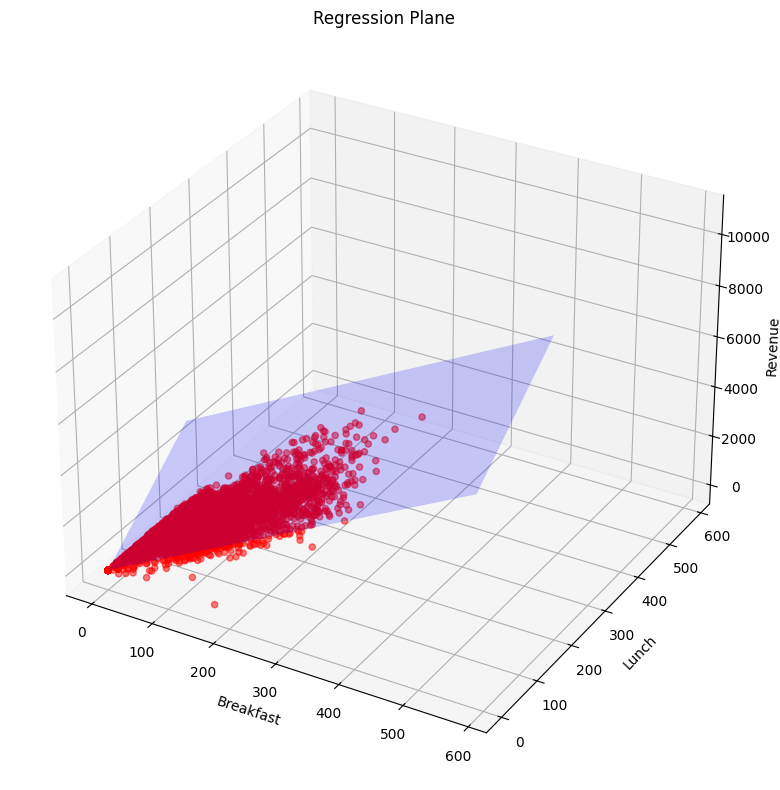

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(meals['Breakfast '], meals['Lunch'], meals['Dinner'], c='red', marker='o', alpha=0.5)

# Creating a meshgrid for the regression plane
xx, yy = np.meshgrid(range(int(meals['Lunch'].min()), int(meals['Lunch'].max())),
                     range(int(meals['Dinner'].min()), int(meals['Dinner'].max())))
zz = results.params['Lunch'] * xx + results.params['Dinner'] * yy # Plane equation: z = const + coef1*x + coef2*y
ax.plot_surface(xx, yy, zz, color='blue', alpha=0.2)

ax.set_xlabel('Breakfast')
ax.set_ylabel('Lunch')
ax.set_zlabel('Revenue')
ax.set_title('Regression Plane')
plt.tight_layout()  
plt.show()

### Estimation (70% data used for training)

In [8]:
# Add a constant term for the intercept (statsmodels OLS does not add an intercept by default)
meals_intercept = sm.add_constant(meals)

# Train/Test split (30% data for testing)
X_train, X_test, y_train, y_test = model_selection.train_test_split(meals_intercept, revenue, test_size=0.3, random_state=0)

# Fit the OLS model
model = sm.OLS(y_train, X_train) 
results = model.fit()

# Obtaining predictions
predictions = results.predict(X_test)

# Plotting predicted results along with actual values
predictions_df = pd.DataFrame(predictions, index=X_test.index, columns=['Predicted'])
test_results_df = X_test.join(predictions_df).join(y_test.rename('Actual'))
test_results_df

,const,Breakfast,Lunch,Dinner,Predicted,Actual
8346,1.0,4,75,26,1411.387045,1256.73
692,1.0,26,64,11,1440.693147,1174.74
8052,1.0,4,47,34,1176.082212,1380.76
7023,1.0,3,160,72,3229.371300,2868.71
6352,1.0,15,185,33,3155.184062,2650.33
...,...,...,...,...,...,...
4428,1.0,8,66,1,970.286196,955.23
4999,1.0,11,187,98,4144.267929,4700.13
4905,1.0,12,144,11,2216.149670,1638.56
7247,1.0,10,94,40,1993.524091,1780.64


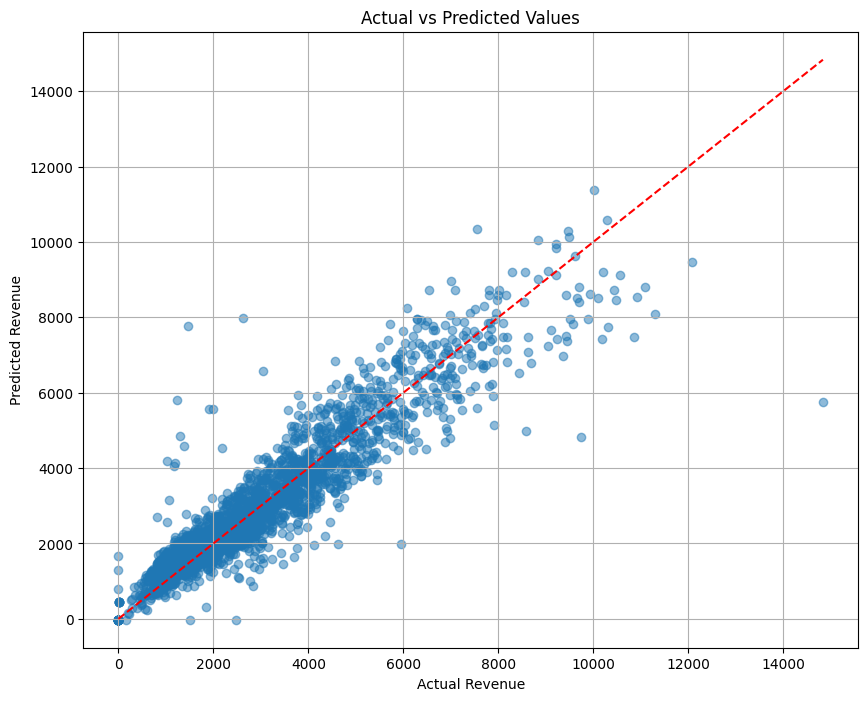

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(test_results_df['Actual'], test_results_df['Predicted'], alpha=0.5)
plt.plot([test_results_df['Actual'].min(), test_results_df['Actual'].max()], 
         [test_results_df['Actual'].min(), test_results_df['Actual'].max()], 
         '--', color='red')  # Plot a diagonal line for reference
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.grid(True)
plt.show()

**Model Evaluation**
*  MAE gives you an idea of how large your prediction errors are, on average.
*  MSE punishes larger errors more severely by squaring them, so a model with big discrepancies will have a worse MSE.
*  RMSE is on the same scale as the outcome variable, making it more interpretable than MSE.
*  R-squared tells the proportion of variance explained by the model. 

In [10]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Absolute Error (MAE): 454.69
Mean Squared Error (MSE): 485920.06
Root Mean Squared Error (RMSE): 697.08
R-squared: 0.87


## Gradient Boosting Regressor

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

# Fit the GB regressor
gb_regressor = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=0)
gb_regressor.fit(X_train, y_train)

# Predict on the test data and plot results
predictions = gb_regressor.predict(X_test)

# Evaluate the model
print("R-squared:", r2_score(y_test, predictions))

R-squared: 0.8829013753125748


### Hyperparameter Tuning

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

# Define the parameter grid to search
param_grid = {'n_estimators': [40, 50, 60], 
              'learning_rate': [0.1, 0.25, 0.5],
              'max_depth': [3, 4, 5],
              'min_samples_split': [3, 4, 5],
              'min_samples_leaf': [1, 2, 3]}

# Create the base model
gb_regressor = GradientBoostingRegressor(random_state=0)

# Fit the grid search to the data
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# The best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Get the best estimator directly
best_gb_regressor = grid_search.best_estimator_

# Predict with the best estimator
y_pred = best_gb_regressor.predict(X_test)

# Evaluate the best model
print("R-squared:", r2_score(y_test, y_pred))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 50}
R-squared: 0.8837874914767673


## Neural Network

IMP! Neural networks often require feature scaling for better performance:

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X = meals.values
y = revenue.values.reshape(-1, 1)

# Converting the data to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(torch.tensor(X).float(), torch.tensor(y).float(), test_size=0.3, random_state=0)

# Create a TensorDataset and DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Define the neural network architecture
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the model, loss function and optimizer
model = RegressionNN()
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training loop
training_losses = []
num_epochs = 200
for epoch in range(num_epochs):
    epoch_losses = []
    for inputs, targets in train_loader:
        optimizer.zero_grad() # Zero the parameter gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, targets) # Compute the loss 
        loss.backward() # Backward pass
        optimizer.step() # Optimize
        epoch_losses.append(loss.item()) # Store bacth loss
    training_losses.append(np.mean(epoch_losses)) # Store mean epoch loss
        
    if (epoch+1) % 10 == 0: # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test)

# Calculate the R-squared score
r2_nn = r2_score(y_test.numpy(), y_pred_nn.numpy())
print(f"Neural Network R-squared Score: {r2_nn:.2f}")

Epoch 10/200, Loss: 515928.2188
Epoch 20/200, Loss: 249432.1719
Epoch 30/200, Loss: 1865274.3750
Epoch 40/200, Loss: 71908.9766
Epoch 50/200, Loss: 318855.5938
Epoch 60/200, Loss: 281412.9062
Epoch 70/200, Loss: 129501.3672
Epoch 80/200, Loss: 207171.0938
Epoch 90/200, Loss: 234433.2031
Epoch 100/200, Loss: 304105.1875
Epoch 110/200, Loss: 201544.5625
Epoch 120/200, Loss: 1902407.6250
Epoch 130/200, Loss: 449109.0938
Epoch 140/200, Loss: 256807.0625
Epoch 150/200, Loss: 362594.1562
Epoch 160/200, Loss: 279989.8125
Epoch 170/200, Loss: 477866.2500
Epoch 180/200, Loss: 466242.5312
Epoch 190/200, Loss: 491673.4688
Epoch 200/200, Loss: 739682.6875
Neural Network R-squared Score: 0.88


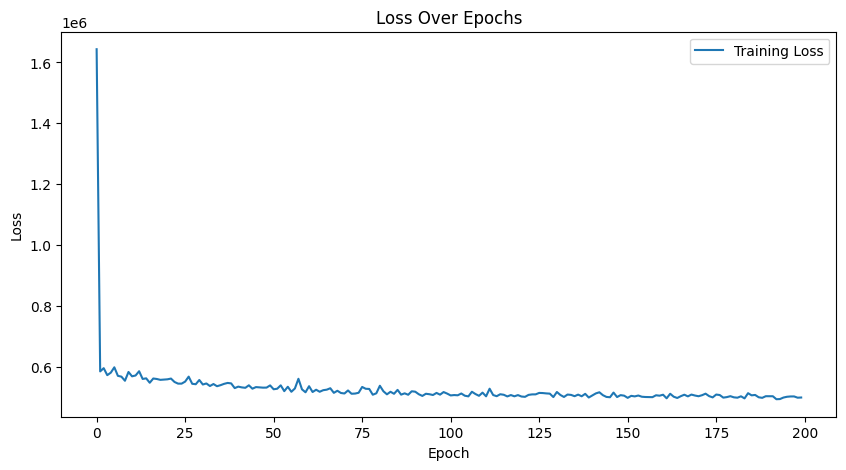

In [17]:
# Plot the training losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
y_test = y_test.flatten() # Flatten y_test to ensure it's a 1D array
X_test_df = pd.DataFrame(X_test.numpy(), columns=meals.columns) # Convert the test set back to a DataFrame
X_test_df['Actual'] = y_test
X_test_df['Predicted'] = y_pred_nn
X_test_df

,Breakfast,Lunch,Dinner,Actual,Predicted
0,4.0,75.0,26.0,1256.729980,1543.398804
1,26.0,64.0,11.0,1174.739990,1180.864258
2,4.0,47.0,34.0,1380.760010,1361.827148
3,3.0,160.0,72.0,2868.709961,2993.941650
4,15.0,185.0,33.0,2650.330078,3402.086670
...,...,...,...,...,...
2625,8.0,66.0,1.0,955.229980,1120.029541
2626,11.0,187.0,98.0,4700.129883,3991.634277
2627,12.0,144.0,11.0,1638.560059,1826.655396
2628,10.0,94.0,40.0,1780.640015,2232.968994


## ARIMA (time series)

1. **Observe seasonality** with line graph, and transform data if needed (with log/square-root transformations or differencing). ARIMA requires seasonality!!!

In [15]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# First, ensure that the 'Date' column is in datetime format and set it as the index
#data['Date'] = pd.to_datetime(data['Date'])
#data.set_index('Date', inplace=True)
revenue_series = data['Revenue'].dropna() # Drop NA values if any

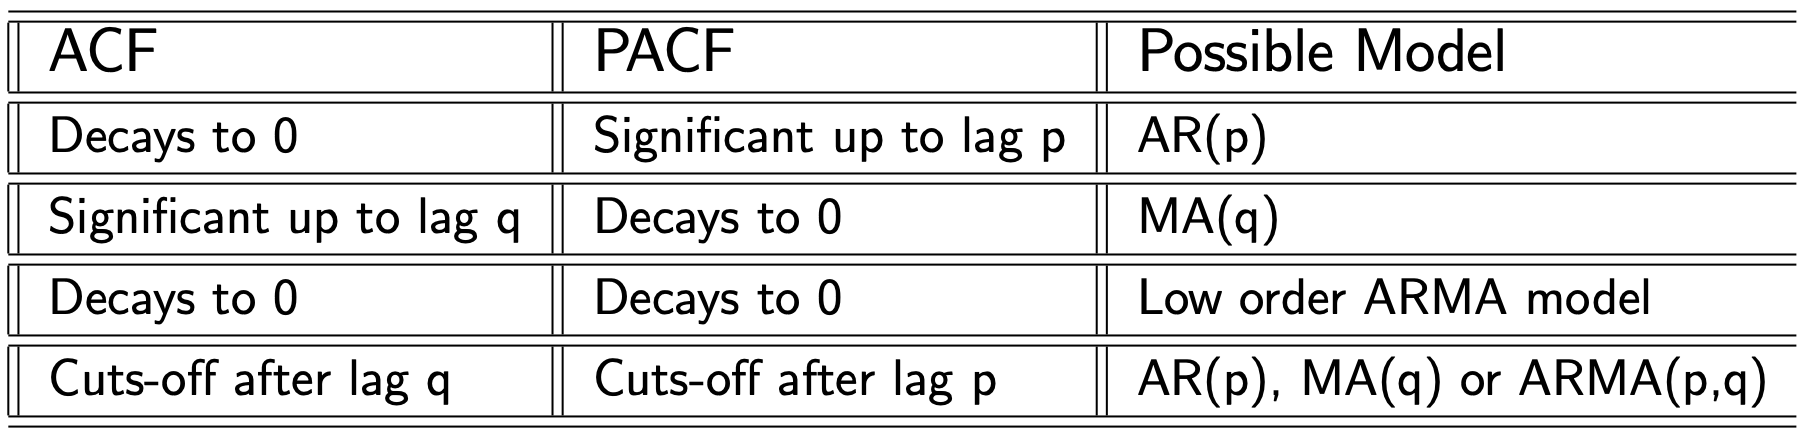

2. **Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to determine order**.

<Figure size 640x480 with 0 Axes>

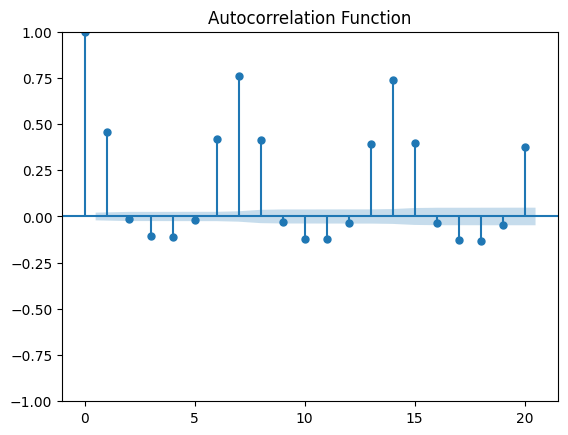

<Figure size 640x480 with 0 Axes>

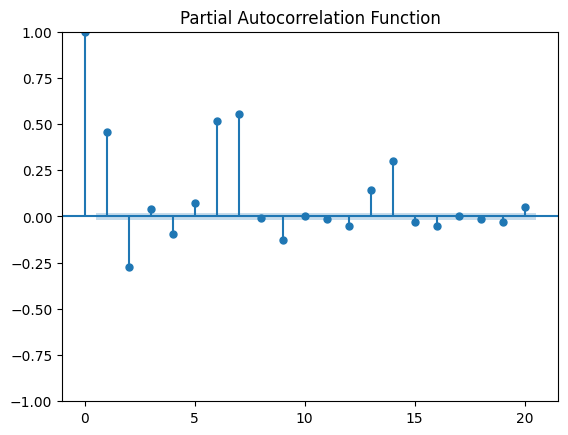

In [12]:
# Plot the ACF
plt.figure()
plot_acf(revenue_series, lags=20)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function')

# Plot the PACF
plt.figure()
plot_pacf(revenue_series, lags=20)  # You can adjust the number of lags as needed
plt.title('Partial Autocorrelation Function')

plt.show()

3. **Fit ARIMA model**. IMP! index (dates) cannot contain duplicates)

In [29]:
from statsmodels.tsa.arima.model import ARIMA

# 'Date' must be index of a TS model, and it cannot contain duplicates. Dates should also be ordered.
data = (data.reset_index().drop_duplicates(subset='Date', keep='last').set_index('Date').sort_index())

# Fit the ARIMA(2,0,0) model
data = data.asfreq('D')
model = ARIMA(data['Revenue'], order=(2, 1, 1), dates=data.index)
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                 8763
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -76249.064
Date:                Mon, 15 Apr 2024   AIC                         152506.128
Time:                        09:28:40   BIC                         152534.440
Sample:                    01-06-2002   HQIC                        152515.775
                         - 01-02-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4765      0.009     50.810      0.000       0.458       0.495
ar.L2         -0.3903      0.010    -37.798      0.000      -0.411      -0.370
ma.L1         -0.9441      0.004   -219.033      0.0

4. **Make predictions**.

In [31]:
# In-sample prediction
in_sample_preds = results.get_prediction(start=pd.to_datetime('2022-01-01'), 
                                         end=pd.to_datetime('2022-12-31'), 
                                         dynamic=False)
in_sample_preds_conf_int = in_sample_preds.conf_int()

# Out-of-sample forecast
out_of_sample_forecast = results.get_forecast(steps=5) # 'steps' is the number of periods you are forecasting ahead
forecast = out_of_sample_forecast.predicted_mean
forecast_conf_int = out_of_sample_forecast.conf_int()

# Print the forecasted values and confidence intervals
print('Predictions:', forecast)
print('Confidence intervals:', forecast_conf_int)

Predictions: 2026-01-03    3691.482759
2026-01-04    3527.433114
2026-01-05    3443.615346
2026-01-06    3467.705949
2026-01-07    3511.899529
Freq: D, Name: predicted_mean, dtype: float64
Confidence intervals:             lower Revenue  upper Revenue
2026-01-03     638.822940    6744.142577
2026-01-04      69.138434    6985.727794
2026-01-05     -23.456097    6910.686788
2026-01-06     -47.745439    6983.157336
2026-01-07      -3.566554    7027.365611


## LSTM (time series)

In [8]:
df = data['Total'].values.astype(float).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1)) #data scaling
data_normalized = scaler.fit_transform(df)
data_normalized = torch.FloatTensor(data_normalized).view(-1)

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(data_normalized, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Reshaping the input data to [samples, time steps, features]
X = X.reshape(X.shape[0], seq_length, -1)  # Adding the features dimension

# Creainge training and test sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Defining the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

model = LSTM(input_size=1, hidden_layer_size=100, output_size=1)
loss_function = nn.MSELoss() #Mean Squared Error losss
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3) # Adam optimizer

# Preparing DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=64)

# Training loop
model.train()
for epoch in range(75):  # Adjust the number of epochs as needed
    for seq, labels in train_loader:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels.view(-1, 1))
        single_loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

# Testing loop
model.eval()
with torch.no_grad():
    preds = model(X_test)
    loss = loss_function(preds, y_test.view(-1, 1))
    print(f'Test loss (MSE): {loss.item()}')

epoch: 0 loss: 0.10927065461874008
epoch: 10 loss: 0.037666115909814835
epoch: 20 loss: 0.051517877727746964
epoch: 30 loss: 0.05769536271691322
epoch: 40 loss: 0.0788414254784584
epoch: 50 loss: 0.07177197933197021
epoch: 60 loss: 0.03931744769215584
epoch: 70 loss: 0.058215685188770294
Test loss: 0.08111998438835144


*How to know if the model is good?* Compare its loss with the naive forecast's and the mean forecast's (these are the baselines for a model to perform).

In [9]:
from sklearn.metrics import mean_squared_error

# Naive forecast: the forecast for each point is the actual value of the previous point
y_naive_forecast = y_test[1:]  # Shift the test set to create the naive forecast
y_naive_truth = y_test[:-1]  # Remove the first element that we don't have a forecast for
mse_naive = mean_squared_error(y_naive_truth, y_naive_forecast)
print(f'Naive Forecast MSE: {mse_naive}')

# Mean forecast: the forecast for each point is the mean of the target variable in the training set
y_mean_forecast = np.full_like(y_test, y_train.mean())
mse_mean = mean_squared_error(y_test, y_mean_forecast)
print(f'Mean Forecast MSE: {mse_mean}')

# Compare MSE with the baseline models
print(f'Model MSE: {loss.item()}')  # loss from your model's test predictions
print(f'Is the model better than the naive forecast? {"Yes" if loss.item() < mse_naive else "No"}')
print(f'Is the model better than the mean forecast? {"Yes" if loss.item() < mse_mean else "No"}')

Naive Forecast MSE: 0.11262234300374985
Mean Forecast MSE: 0.1046762466430664
Model MSE: 0.08111998438835144
Is the model better than the naive forecast? Yes
Is the model better than the mean forecast? Yes


# Classification (supervised)

We use **F-1 Score** for evaluation.

In [ ]:
Image(url="https://api.wandb.ai/files/mostafaibrahim17/images/projects/37042936/05cc4b35.png")

IMP! Target value must be **categorical (but encoded into numbers!)**.

In [ ]:
# Encoding categorical variable
days = data["Day"]
encoded_days = preprocessing.LabelEncoder().fit_transform(data["Day"])

# STANDARDIZE DATA BEFORE SPLITTING!!!

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(meals_intercept, encoded_days, test_size=0.3, random_state=0)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(multi_class='ovr', solver='lbfgs', class_weight='balanced')  
results = classifier.fit(X_train, y_train)
y_pred = results.predict(X_test)

In [ ]:
# Model evaluation
score = f1_score(y_test, y_pred, average='weighted') 
cm = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix (i.e. contingency table)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'F-1 Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Fit the GB classifier
gb_classifier = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=0)
gb_classifier.fit(X_train, y_train)

# Predict on the test data
predictions = gb_classifier.predict(X_test)

# Model evaluation
f1 = f1_score(y_test, predictions, average="weighted")  # Use a different name for the variable
print("F-1 score:", f1)

In [ ]:
# Create a DataFrame with actual and predicted categories
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Calculate counts of each category for Actual and Predicted
summary_df = pd.concat([
    results_df['Actual'].value_counts().rename('Actual'),
    results_df['Predicted'].value_counts().rename('Predicted')
], axis=1).fillna(0)  # Fill NaN with 0s in case some categories don't appear in either Actual or Predicted

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
summary_df.plot(kind='bar', ax=ax)
ax.set_title('Comparison of Actual and Predicted Categories')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.xticks(rotation=45)  
plt.legend()
plt.show()

# Clustering (unsupervised)

## K-Means

In [24]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

kmeans = KMeans(init = 'k-means++', n_clusters = 3)
y_pred = kmeans.fit_predict(X_train)

**Visualization**: we need to reduce dimensionality so as to visualize the clusters.

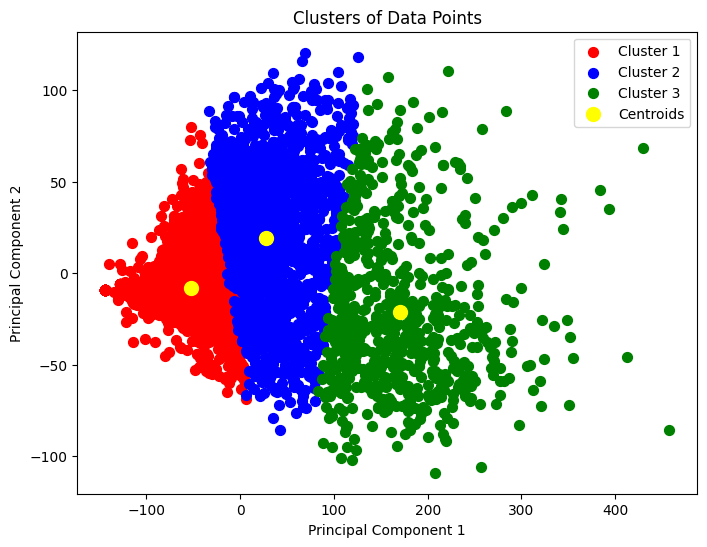

In [26]:
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components=3)  # Choose 3 for 3D visualization or 2 for 2D
X_train_pca = pca.fit_transform(X_train)

# Step 2: Run K-means on the original data
kmeans = KMeans(init='k-means++', n_clusters=3, random_state=42)
y_pred = kmeans.fit_predict(X_train)

# Step 3: 2D Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[y_pred == 0, 0], X_train_pca[y_pred == 0, 1], s=50, c='red', label='Cluster 1')
plt.scatter(X_train_pca[y_pred == 1, 0], X_train_pca[y_pred == 1, 1], s=50, c='blue', label='Cluster 2')
plt.scatter(X_train_pca[y_pred == 2, 0], X_train_pca[y_pred == 2, 1], s=50, c='green', label='Cluster 3')

# Mark the centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, c='yellow', label='Centroids')

plt.title('Clusters of Data Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

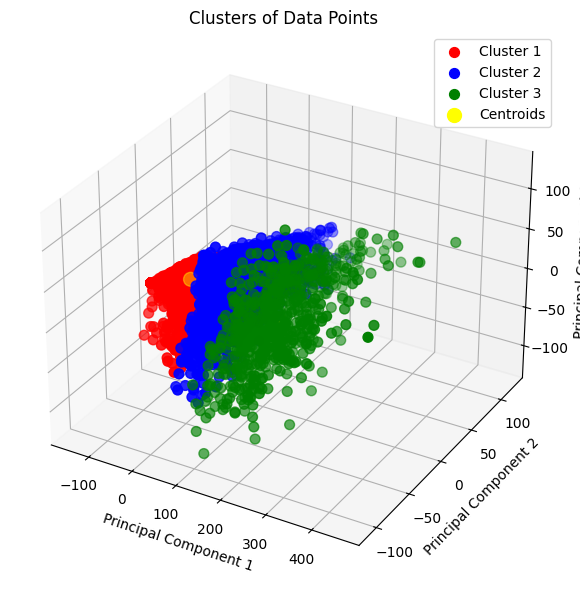

In [28]:
# Step 3: 3D Visualization
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[y_pred == 0, 0], X_train_pca[y_pred == 0, 1], X_train_pca[y_pred == 0, 2], s=50, c='red', label='Cluster 1')
ax.scatter(X_train_pca[y_pred == 1, 0], X_train_pca[y_pred == 1, 1], X_train_pca[y_pred == 1, 2], s=50, c='blue', label='Cluster 2')
ax.scatter(X_train_pca[y_pred == 2, 0], X_train_pca[y_pred == 2, 1], X_train_pca[y_pred == 2, 2], s=50, c='green', label='Cluster 3')

# Mark the centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2], s=100, c='yellow', label='Centroids')

ax.set_title('Clusters of Data Points')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.tight_layout()
plt.show()